In [1]:

import matplotlib.pyplot as plt
#%matplotlib inline

import sys
import os

import scipy.sparse.linalg as spsl

import numpy as np


In [106]:
h1=5
w1=1

def force(x):
    return -h1*4*(x**2-w1)*x;
def energy(x):
    return h1*(x**2-w1)**2

nrSteps = 10000

x = np.ones(nrSteps)
p = np.random.randn(nrSteps)
dt=0.01
gamma = 1
kT = 1
a = np.exp(-gamma * (dt))
b = np.sqrt(1 - np.exp(-2 * gamma * (dt)))


pn = p[0]
xn = x[0]
    
f=force(xn)

for n in range(nrSteps-1):
        
        
        
        pn = pn + 0.5* f * dt
        xn = xn + 0.5* pn * dt
        pn = (a * pn) + b * np.random.randn(*xn.shape) * np.sqrt(kT)
        f=force(xn)
        xn = xn + 0.5* pn * dt
        pn = pn + 0.5* f * dt
        
        p[n+1] = pn
        x[n+1] = xn
    


In [134]:
# take a gaussian as initial conditions.
x = np.random.randn(nrSteps) * 0.1 + 1.0

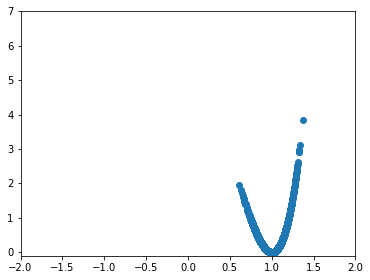

In [108]:
def plotSampling_fromData(x, methodName=None, color='b', title = 'Initial condition', savefigure=None):
    
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    ax.scatter(x, energy(x))
    ax.set_xlim([-2,2])
    ax.set_ylim([-0.1,7])
    if savefigure is not None:
        plt.savefig(savefigure,  format='png', dpi=100, bbox_inches='tight')
        
    plt.show()
        
   
    
plotSampling_fromData(x, methodName=None, color='b', title = 'Initial condition', savefigure=None)

#  Stein force

In [109]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

def compute_force(XL, leader_set):
       
    f = []
    
    for n in range(len(leader_set)):
        f.append( force(XL[leader_set[n]]))

    return f

def compute_force_all(XL):
       
    f = []
    
    for n in range(len(XL)):
        f.append( force(XL[n]))

    return f

def compute_stein_force(XL, leader_set):
   
    my_force = compute_force(XL, leader_set)
    # create numpy array from the list force which has also units    
    force_resh = np.asarray(my_force)
    # create numpy array from the list XL which has also units
    
    # choose leader particles using the index set leader_set
    X_leader = XL[leader_set]
   
    # kernel scaling parameter
    h=0.02
    
    distances = cdist(XL[:,np.newaxis], X_leader[:,np.newaxis])
    kernel = np.exp(-distances**2 / h)
    
    # this computes the first part (without the kernel derivatives)
    # f_MDforce is of the format (N_particles, dim)
    f_MDforce = np.dot(kernel, force_resh)
    f_MDforce = f_MDforce / len(leader_set)
    # add force unit and divide by kT
    #f_MDforce = f_MDforce * model.force_unit / smpl.kT
    f_MDforce = f_MDforce  / kT
    
    #derivative part
    f_der = -2.0/h * np.dot(kernel, X_leader)
    f_der += 2.0/h * np.sum(kernel,1) * XL
    f_der = f_der / len(leader_set)
    # add unit
    #f_der = f_der * model.x_unit**(-1)
    
    return f_MDforce + f_der



# Iterate Stein

In [110]:
#from scipy.spatial.distance import cdist
#dist = cdist(X_short[:,np.newaxis], X_short[:,np.newaxis])

#np.median(dist)**2/ (2*np.log(200) + 1)

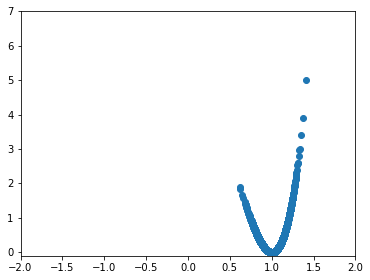

Stein iteration 0


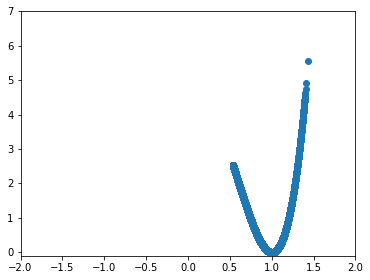

Stein iteration 500


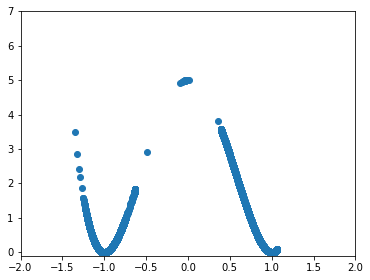

Stein iteration 1000


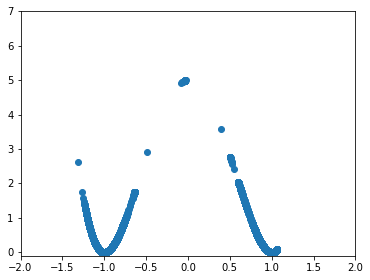

Stein iteration 1500


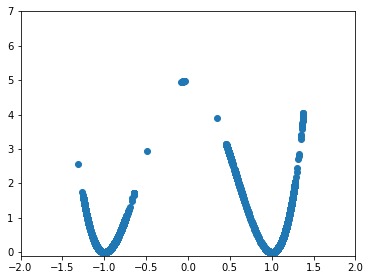

Stein iteration 2000


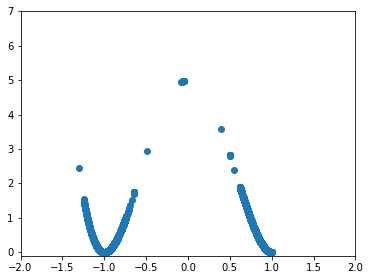

Stein iteration 2500


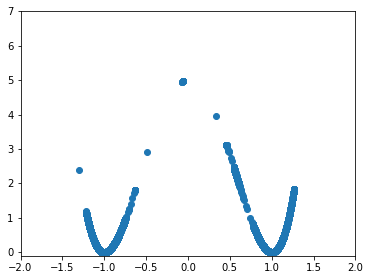

Stein iteration 3000


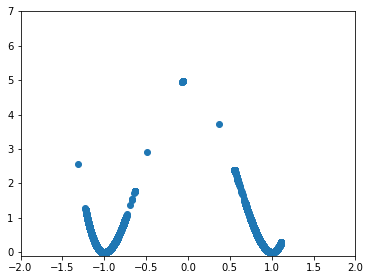

Stein iteration 3500


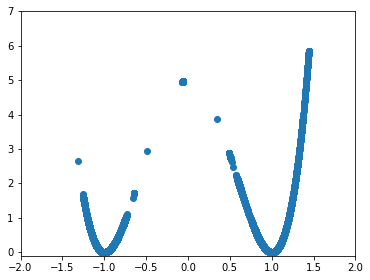

Stein iteration 4000


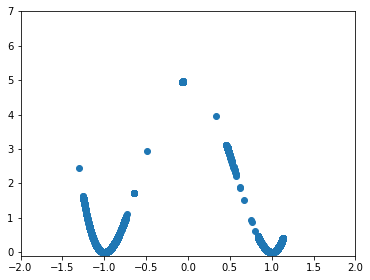

Stein iteration 4500


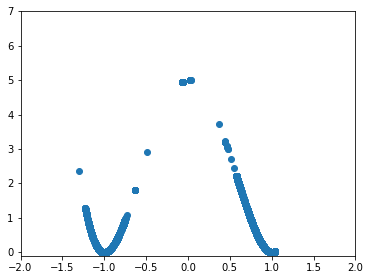

Stein iteration 5000


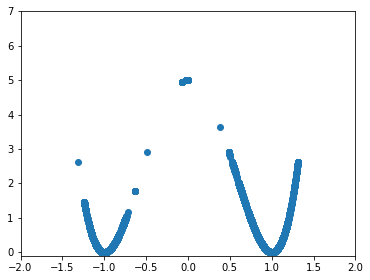

Stein iteration 5500


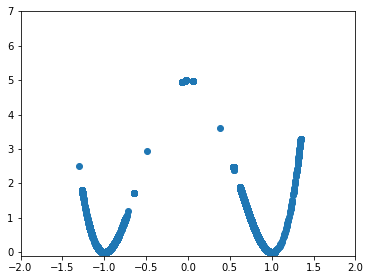

Stein iteration 6000


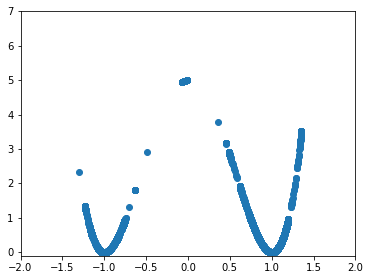

Stein iteration 6500


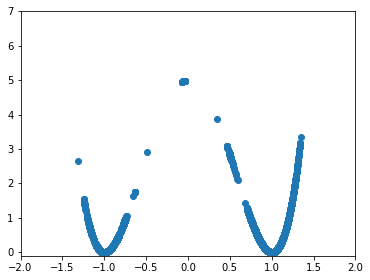

Stein iteration 7000


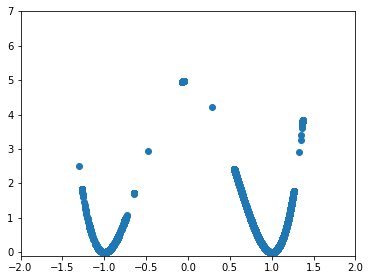

Stein iteration 7500


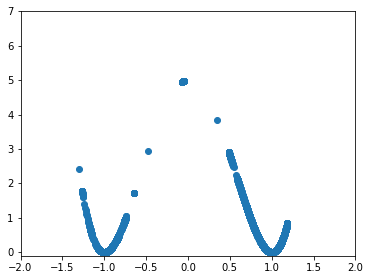

Stein iteration 8000


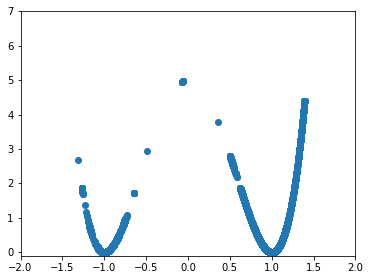

Stein iteration 8500


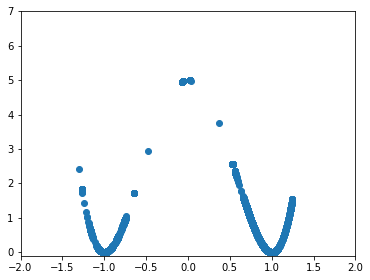

Stein iteration 9000


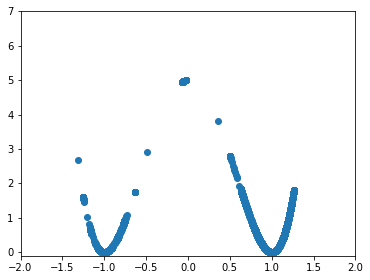

Stein iteration 9500


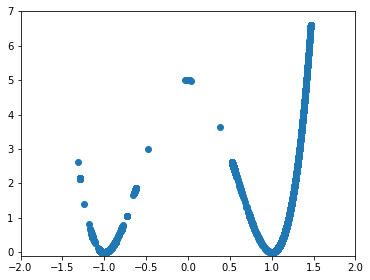

In [135]:
numberOfSteinSteps = 10000#50000

X_short = np.copy(x)

epsilon_step=0.15

# choose leader set
numberOfLeaderParticles = int(0.01*(X_short.shape[0]))
leader_set = np.random.choice(range(X_short.shape[0]), numberOfLeaderParticles)#np.array(range(X_short.shape[0]))# 

mass = 1 

q = X_short

XL=np.copy(q)
plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition')
f = compute_stein_force(XL,leader_set)
#f = compute_force(XL)

modit = int(numberOfSteinSteps/20)
moditfig = int(numberOfSteinSteps/20)

for ns in range(numberOfSteinSteps):
    if ns%modit==0:
        print('Stein iteration '+repr(ns))
    f = compute_stein_force(XL,leader_set)
    XL = (XL + epsilon_step * f)#/mass );
    q =  np.copy(XL)
    
    ## plot progress
    if ns%moditfig==0:
        plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition', savefigure=None)
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break
    

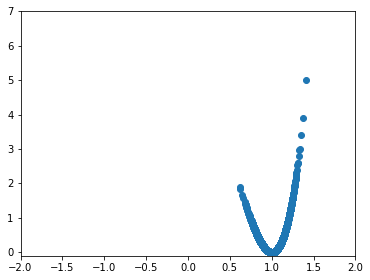

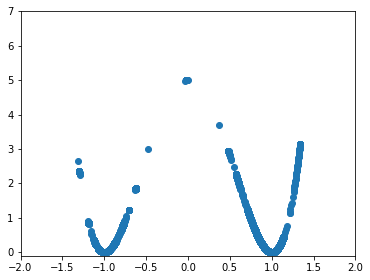

In [136]:
plotSampling_fromData(x,  methodName=None, color='b', title='Initial state')
#plotSampling_fromData(x[leader_set],  methodName=None, color='r', title='Initial state')
plotSampling_fromData(q, methodName=None, color='b', title = 'After '+repr(numberOfSteinSteps)+' Stein steps')
#plotSampling_fromData(q[leader_set], methodName=None, color='b', title = 'After '+repr(numberOfSteinSteps)+' Stein steps')


In [137]:
from scipy.integrate import quadrature
def fit_distribution(x):
    #x = x[:,0,0]
    xx = np.linspace(-2,2,100)
    Z = sum(np.exp(-energy(xx))) * (xx[1]-xx[0])
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    ax.hist(x, 40, density=True);
    ax.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
   
    plt.show()

In [138]:
#fit_distribution(q)


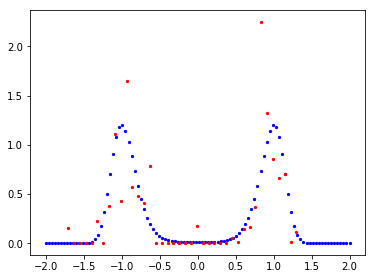

In [139]:
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(111)
x = q
data, bins = np.histogram(x, 40, density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
Z = sum(np.exp(-energy(xx))) * (xx[1]-xx[0])
xx = np.linspace(-2,2,100)
ax.scatter(xx, np.exp(- energy(xx))/Z , c='b', s=5)
ax.scatter(bin_centers, data , c='r', s=5)
plt.show()

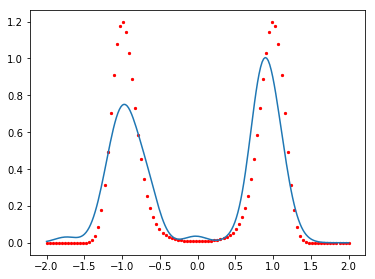

In [140]:
from sklearn.neighbors.kde import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(q.reshape(-1,1))

X_plot = np.linspace(-2, 2, 200)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)

fig = plt.figure(figsize=(6,4.5))
plt.plot(X_plot[:, 0], np.exp(log_dens), '-')
plt.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.show()

In [141]:
q.reshape(-1,1).shape

(10000, 1)

In [82]:
data.shape

(40,)

In [ ]:
Z = 0.5725340617
print('Z='+repr(Z))

print('E[x] = 0')
print(np.mean(X_short))
print(np.mean(q))
print('************')

print('E[V(x)] = 0.5247724179')
print(np.mean(energy(X_short)))
print(np.mean(energy(q)))

print('E[-f(x)*x] = 1')
print(np.mean((-force(X_short)* X_short)))
print((np.mean(-force(q)* q)))

In [ ]:
import glob
import moviepy.editor as mpy

gif_name = 'SteinFigures/stein'
fps = 1000
file_list = glob.glob('SteinFigures/'+'/*.png') # Get all the pngs in the current directory
list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case
clip = mpy.ImageSequenceClip(file_list, fps=fps)
clip.write_gif('{}.gif'.format(gif_name), fps=fps)

In [ ]:
q.shape